## Template detection in image with cv2.matchTemplate

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

image = mpimg.imread('/home/markus/udacity/Projekte/CarNDVehicleDetectionP1/test_images/template_matching/bbox-example-image.jpg')
templist = glob.glob('/home/markus/udacity/Projekte/CarNDVehicleDetectionP1/test_images/template_matching/cutout*.jpg')
# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    
    return draw_img # Change this line to return image copy with boxes
# Add bounding boxes in this format, these are just example coordinates.
    
def find_matches(img, template_list):
    # Make a copy of the image to draw on
    # Define an empty list to take bbox coords
    bbox_list = []
    # Iterate through template list
    # Read in templates one by one
    for temp in templist:
        img_tmp = mpimg.imread(temp)
        match = cv2.matchTemplate(img,img_tmp,method=0)
        minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(match)
        bbox_list.append((minLoc,(minLoc[0]+img_tmp.shape[1],minLoc[1]+img_tmp.shape[0])))
    return bbox_list

bboxes = find_matches(image,templist)
result = draw_boxes(image, bboxes)
plt.imshow(result)

# Build and Train a Classifier for Car Detection in Images

In this section the classifier is designed that will later be used to detect cars in a video stream. In the next section the training of the classifier is addressed.

In [1]:
# import packages that are required for computations in this notebook
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

For the training of the classifier, the vehicle and non-vehicle images of the git repository training_datasets will be used. The file paths to the images are first loaded with glob and stored in the lists cars[] and nocars[] respectively.

In [2]:
cars = glob.glob('./training_datasets/vehicles_small/*/*.jpeg', recursive=True)
nocars = glob.glob('./training_datasets/non-vehicles_small/*/*.jpeg', recursive=True)

In the following the 'RGB' representation of a randomly selected car image will be transformed into different color spaces and the pixel values of the test image will be shown in 3d plots for each colorspace.

In [57]:
from mpl_toolkits.mplot3d import Axes3D

def plot3d(imglist, colors_rgb,
        csplist, axis_limits=[(0, 255), (0, 255), (0, 255)]):

    # Create figure and 3D axes
    fig = plt.figure(figsize=(15, 10))
    for i in range(len(imglist)):
        pixels = imglist[i]
        axis_labels = list(csplist[i])
        
        ax = fig.add_subplot(2,3,i+1,projection='3d')

        # Set axis limits
        ax.set_xlim(*axis_limits[0])
        ax.set_ylim(*axis_limits[1])
        ax.set_zlim(*axis_limits[2])

        # Set axis labels and sizes
        ax.tick_params(axis='both', which='major', labelsize=8, pad=8)
        ax.set_xlabel(axis_labels[0], fontsize=8, labelpad=8)
        ax.set_ylabel(axis_labels[1], fontsize=8, labelpad=8)
        ax.set_zlabel(axis_labels[2], fontsize=8, labelpad=8)

        # Plot pixel values with colors given in colors_rgb
        ax.scatter(
            pixels[:, :, 0].ravel(),
            pixels[:, :, 1].ravel(),
            pixels[:, :, 2].ravel(),
            c=colors_rgb.reshape((-1, 3)), edgecolors='none')
    plt.show()

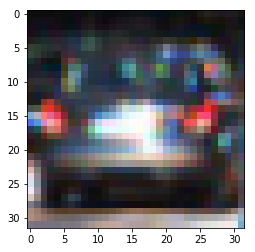

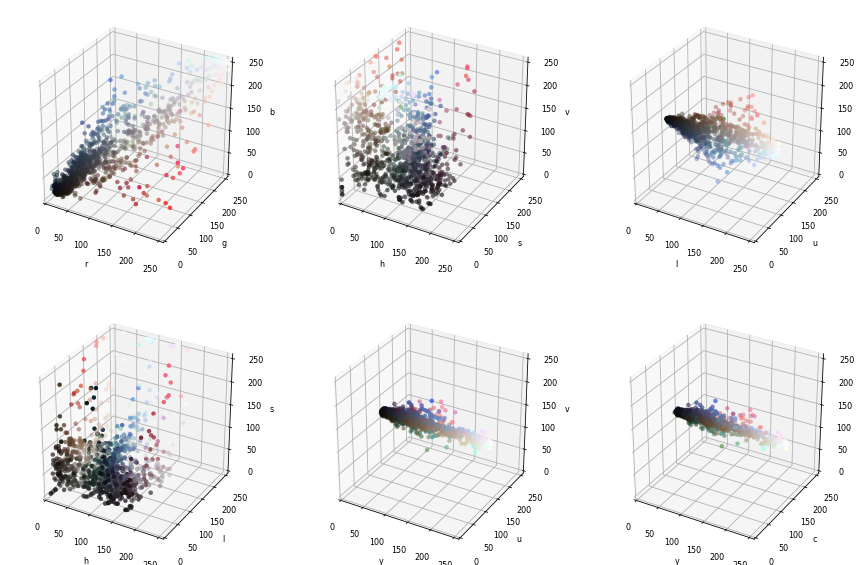

In [76]:
sel = np.random.randint(0,len(cars))
img = cv2.cvtColor(cv2.imread(cars[sel]), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, dsize=(32,32), interpolation=cv2.INTER_NEAREST)
plt.imshow(img)
img_rgb = np.copy(img)
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
img_luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
img_ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
img_rgbc = img_rgb / 255.

img_list = [img_rgb,img_hsv,img_luv,img_hls,img_yuv,img_ycrcb]
csp_list = ['rgb','hsv','luv','hls','yuv','ycrcb']

plot3d(img_list,img_rgbc,csp_list)

=> Especially the 'HLS' and 'HSV' colorspaces show a nice separation of car pixels and background so that a transformation into these colorspaces might be able to help the classification.

In the following section the functions for feature extraction from a test image are defined. These are:

* color histograms
* spatial color binning
* and hog features

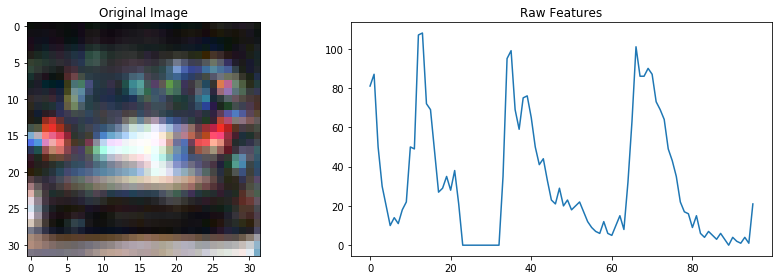

In [77]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

# print (HLS) color histogram for test image
f_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(122)
plt.plot(color_hist(f_img))
plt.title('Raw Features')
fig.tight_layout()

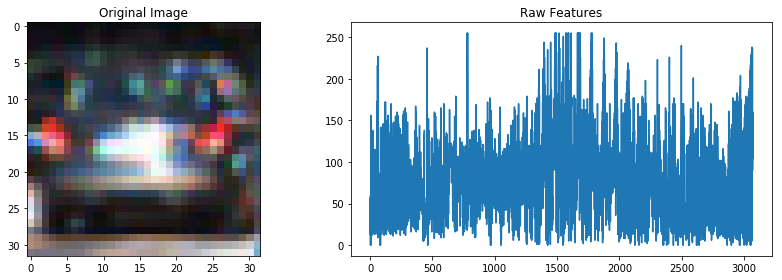

In [78]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

# print (HLS) spatial binning for same test image as above
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(122)
plt.plot(bin_spatial(f_img))
plt.title('Raw Features')
fig.tight_layout()

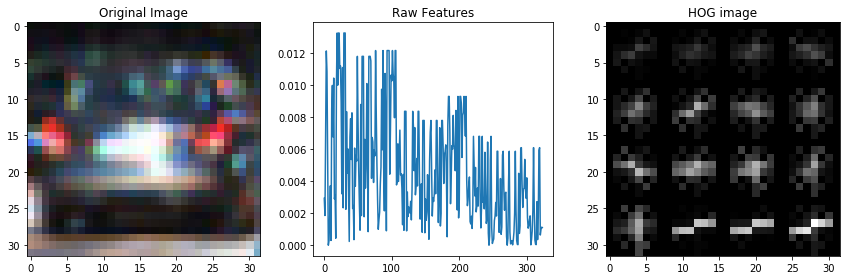

In [80]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm='L2-Hys', transform_sqrt=False, 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm='L2-Hys', transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
# print hog features for grayscale version of same test image as above
f_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
hog_features,hog_image = get_hog_features(f_img,vis=True)
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(132)
plt.plot(hog_features)
plt.title('Raw Features')
plt.subplot(133)
plt.imshow(hog_image,cmap='gray')
plt.title('HOG image')
fig.tight_layout()

Next, the functions defined above are called from the function extract_features. The output of this function is a concatenated feature array that will be used for classification of images and/or video streams.

In [81]:
import time
def extract_features(imgstrs, cspace='BGR', hist_bins=32, hist_range=(0, 256),
                                            spatial_size=(32, 32),
                                            orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                                            colhist=True, spatial=True, hog=True, print_time=False):
    features = []
    for imgstr in imgstrs:
        img = cv2.imread(imgstr)
        t0 = time.time()
        if cspace != 'BGR':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(img)
        features_colhist=[]
        features_spatial=[]
        features_hog=[]
        if(colhist==True):
            t1 = time.time()
            features_colhist = color_hist(feature_image,nbins=hist_bins,bins_range=hist_range)
            t2 = time.time()
        if(spatial==True):
            features_spatial = bin_spatial(feature_image,size=spatial_size)
            t3 = time.time()
        if(hog==True):
            if hog_channel == 'ALL':
                features_hog=[]
                for channel in range(feature_image.shape[2]):
                    ch_feats = get_hog_features(feature_image[:,:,channel], 
                                                orient, pix_per_cell, cell_per_block, 
                                                vis=False, feature_vec=False).ravel()
                    features_hog.append(ch_feats)
                features_hog = np.hstack(features_hog)
            else:
                features_hog = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block,
                                                vis=False, feature_vec=True)
            t4 = time.time()
        features.append(np.concatenate((features_spatial,features_colhist,features_hog)))
        
        if(print_time==True):
            print(round(t1-t0, 4), 's; time for color conversion')
            print(round(t2-t1, 4), 's; time for extraction of color histogram')
            print(round(t3-t2, 4), 's; time for extraction of spatial color bin')
            print(round(t4-t3, 4), 's; time for extraction of hog features')
    return features

The functions are now applied and with the extracted features the classifier is trained:

In [82]:
from sklearn.preprocessing import StandardScaler

# extract features from images:
car_features = extract_features(cars, cspace='YCrCb')
nocar_features = extract_features(nocars, cspace='YCrCb')

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, nocar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
else:
    print('function only returns empty feature vectors...')
        
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(nocar_features))))

In [87]:
from sklearn.model_selection import train_test_split

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

In [91]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import time

#parameters = {'C':[1, 10]}
#clf = SVC(kernel='linear')
clf = LinearSVC()
#clf = GridSearchCV(svr, parameters) 
#print(clf.best_params_)

# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

0.57 Seconds to train SVC...
Test Accuracy of SVC =  0.9892
My SVC predicts:  [ 0.  0.  1.  1.  0.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  1.  0.  1.  1.  0.]
0.00125 Seconds to predict 10 labels with SVC


# Detect cars in images by sliding window search

In [92]:
def convert_color(img, cspace='HLS'):
    if cspace == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif cspace == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif cspace == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif cspace == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    elif cspace == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else: print('no admissible colorspace selected')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale,
              clf, X_scaler,
              orient=9, pix_per_cell=8, cell_per_block=2,
              spatial_size=32,
              hist_bins=32):
    
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = img_tosearch[:,:,0]
    ch2 = img_tosearch[:,:,1]
    ch3 = img_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            subimg = img_tosearch[ytop:ytop+window, xleft:xleft+window]
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=(spatial_size,spatial_size))
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            features = ((np.concatenate((spatial_features, hist_features, hog_features))).reshape(1,-1)).astype(np.float64)
            features_scaled = X_scaler.transform(features)
            #features_scaled = X_scaler.transform(np.hstack((spatial_features, hist_features)).reshape(1, -1))    
            test_prediction = clf.predict(features_scaled)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return bbox_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    
    return draw_img

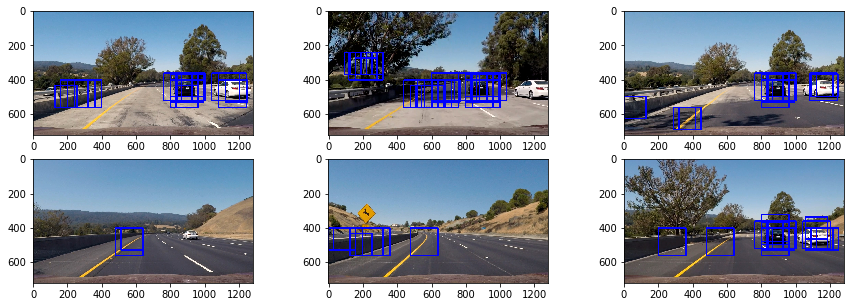

In [100]:
imgstrs = glob.glob('./test_images/*.jpg')

plt.figure(figsize=(15,5))
i=0
for imgstr in imgstrs:
    img = cv2.imread(imgstr)
    s_img = convert_color(img, cspace='YCrCb')
    i=i+1
    plt.subplot(2,3,i)
    bboxes1 = []
    bboxes2 = []
    bboxes3 = []
    #bboxes1 = find_cars(s_img, np.int(img.shape[0]*(1/2)), np.int(img.shape[0]*(2/3)), 1.,
    #                    clf, X_scaler)
    bboxes2 = find_cars(s_img, np.int(img.shape[0]*(1/3)), np.int(img.shape[0]), 2.,
                        clf, X_scaler)
    bboxes3 = find_cars(s_img, np.int(img.shape[0]*(1/3)), np.int(img.shape[0]), 2.5,
                        clf, X_scaler)
    bboxes = bboxes1+bboxes2+bboxes3
    
    img_det = draw_boxes(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),bboxes)
    plt.imshow(img_det)

# Apply search on video stream

In [101]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [102]:
global heatmap
heatmap = np.zeros_like(img[:,:,0].astype(np.float))

def add_heat(heatmap, bbox_list, threshold=3):
    heatmap = np.clip(heatmap,1,255)-1
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 2
    heatmap = np.clip(heatmap,0,threshold+5)
    heatplot = heatmap
    heatplot[heatmap <= threshold] = 0
    return heatplot
    
def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

In [110]:
from scipy.ndimage.measurements import label

def process_image(img):
    img_p = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    bboxes1 = find_cars(img_p, np.int(img.shape[0]*(1/3)), np.int(img.shape[0]*(5/6)), 1.,
                        clf, X_scaler)
    bboxes2 = find_cars(img_p, np.int(img.shape[0]*(1/3)), np.int(img.shape[0]), 2.,
                        clf, X_scaler)
    bboxes3 = find_cars(img_p, np.int(img.shape[0]*(1/3)), np.int(img.shape[0]), 2.5,
                        clf, X_scaler)
    bboxes = bboxes1+bboxes2+bboxes3
    
    #heat = add_heat(heatmap,bboxes,5)
    #labels = label(heat)
    #img_det = draw_labeled_bboxes(np.copy(img), labels)
    img_det = draw_boxes(img,bboxes)
    return img_det

In [ ]:
video_output = './test_videos_output/project_video.mp4'
video_input = VideoFileClip("./test_videos_input/project_video.mp4")
clip = video_input.fl_image(process_image)#.subclip(0,5) #NOTE: this function expects color images!!
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./test_videos_output/project_video.mp4
[MoviePy] Writing video ./test_videos_output/project_video.mp4



  0%|          | 4/1261 [00:06<31:40,  1.51s/it]